# 📊 Classificador de Comentários - Exploração de Dados e Treinamento de Modelo

**Projeto**: Reconhecimento de Padrões para Classificação de Texto  
**Objetivo**: Construir um classificador binário para análise de sentimentos (positivo/negativo)

---

## 📋 Visão Geral do Notebook

Este notebook cobre todo o pipeline de aprendizado de máquina:

1. **Carregamento dos Dados** - Carregar _word embeddings_ pré-computados e vetores de texto
2. **Exploração de Dados** - Analisar características do dataset e distribuição das classes
3. **Treinamento do Modelo** - Treinar Regressão Logística com balanceamento de classes
4. **Avaliação do Modelo** - Avaliar desempenho usando acurácia, precisão, revocação e F1-score
5. **Testes** - Testar o classificador com comentários em português

---

## 🎯 Principais Recursos

-   ✅ Usa _word embeddings_ de 100 dimensões pré-computados
-   ✅ Lida com desbalanceamento via pesos de classe
-   ✅ Divisão estratificada treino/validação/teste (70%/15%/15%)
-   ✅ Saídas formatadas com tabelas, painéis e métricas coloridas
-   ✅ Classificação interativa de comentários

---

Vamos começar! 🚀


In [1]:
# Standard library
from pathlib import Path

# Third-party imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.typing import NDArray

# Rich imports for beautiful terminal output
from rich.console import Console
from rich.table import Table
from rich.panel import Panel
from rich.markdown import Markdown
from rich import box

# Initialize Rich console
console = Console()

# Configure matplotlib
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

In [2]:
def load_project_data() -> tuple[
    list[str],  # Vocabulário
    NDArray[np.float32],  # Word embeddings (9538 × 100)
    NDArray[np.float32],  # Vetores de texto (10400 × 100)
    NDArray[np.int32],  # Rótulos (10400,)
]:
    """
    Carrega todos os dados do projeto do diretório resources.

    Retorna:
        vocabulary: Lista com 9.538 palavras
        word_embeddings: Vetores de palavras (9538 linhas, 100 colunas)
        text_embeddings: Vetores de texto pré-computados (10400 linhas, 100 colunas)
        labels: Rótulos binários (1=positivo, 0=negativo)
    """
    # Caminho notebooks/ -> resources/
    resources = Path.cwd().parent / "resources"

    console.print(
        Panel.fit(
            f"[bold cyan]📂 Carregando dados de:[/bold cyan]\n[yellow]{resources}[/yellow]",
            title="[bold white]Carregamento de Dados[/bold white]",
            border_style="cyan",
        )
    )

    # Carrega vocabulário (uma palavra por linha)
    with open(resources / "PALAVRASpc.txt", "r", encoding="utf-8") as f:
        vocabulary = [line.strip() for line in f]

    # Carrega word embeddings (9538 × 100)
    word_embeddings = np.loadtxt(resources / "WWRDpc.dat", dtype=np.float32)

    # Carrega vetores de texto pré-computados (10400 × 100)
    text_embeddings = np.loadtxt(resources / "WTEXpc.dat", dtype=np.float32)

    # Carrega rótulos (10400 valores: 0 ou 1)
    labels = np.loadtxt(resources / "CLtx.dat", dtype=np.float32).astype(np.int32)

    console.print("[bold green]✅ Dados carregados com sucesso![/bold green]\n")

    return vocabulary, word_embeddings, text_embeddings, labels


# Executa a função
vocabulary, word_embeddings, text_embeddings, labels = load_project_data()

╭────────────── Carregamento de Dados ───────────────╮
│ 📂 Carregando dados de:                            │
│ c:\Users\victo\Desktop\comment-classfier\resources │
╰────────────────────────────────────────────────────╯

✅ Dados carregados com sucesso!

In [3]:
# Tabela de visão geral do dataset
overview_table = Table(
    title="[bold white]📊 Visão Geral do Dataset[/bold white]",
    show_header=True,
    header_style="bold magenta",
    border_style="blue",
    box=box.ROUNDED,
)

overview_table.add_column("Componente", style="cyan", width=20)
overview_table.add_column("Detalhes", style="yellow")
overview_table.add_column("Formato/Quantidade", justify="right", style="green")

# Linhas com informações dos dados
overview_table.add_row(
    "🔤 Vocabulário",
    f"10 primeiras palavras: {', '.join(vocabulary[:10])}...",
    f"{len(vocabulary):,} palavras",
)
overview_table.add_row(
    "📐 Word Embeddings",
    f"Cada palavra → {word_embeddings.shape[1]} dimensões",
    f"{word_embeddings.shape[0]:,} × {word_embeddings.shape[1]}",
)
overview_table.add_row(
    "📝 Vetores de Texto",
    "Comentários pré-vetorizados",
    f"{text_embeddings.shape[0]:,} × {text_embeddings.shape[1]}",
)

# Distribuição de rótulos
positive_count = np.sum(labels == 1)
negative_count = np.sum(labels == 0)
positive_pct = (positive_count / len(labels)) * 100
negative_pct = (negative_count / len(labels)) * 100

overview_table.add_row(
    "🏷️  Rótulos (Total)",
    f"Positivo: {positive_count:,} ({positive_pct:.1f}%) | Negativo: {negative_count:,} ({negative_pct:.1f}%)",
    f"{len(labels):,} amostras",
)

console.print(overview_table)

# Painel separado com distribuição de rótulos
label_info = f"""
[bold cyan]Distribuição das Classes:[/bold cyan]
├─ [green]Positivo (1):[/green] {positive_count:,} amostras ({positive_pct:.1f}%)
└─ [red]Negativo (0):[/red] {negative_count:,} amostras ({negative_pct:.1f}%)

[bold yellow]⚠️  Nota:[/bold yellow] O dataset é desbalanceado - mais exemplos negativos!
"""

console.print(
    Panel(
        label_info.strip(),
        title="[bold white]Análise dos Rótulos[/bold white]",
        border_style="yellow",
        box=box.DOUBLE,
    )
)

                                             📊 Visão Geral do Dataset                                             
╭──────────────────────┬─────────────────────────────────────────────────────────────────────┬────────────────────╮
│ Componente           │ Detalhes                                                            │ Formato/Quantidade │
├──────────────────────┼─────────────────────────────────────────────────────────────────────┼────────────────────┤
│ 🔤 Vocabulário       │ 10 primeiras palavras: IMENSA, TOA, SABENDO, SABEMOS, NISTO,        │     9,538 palavras │
│                      │ SABERMOS, SABEREMOS, SABEREM, SABERIAMOS, SABERIA...                │                    │
│ 📐 Word Embeddings   │ Cada palavra → 100 dimensões                                        │        9,538 × 100 │
│ 📝 Vetores de Texto  │ Comentários pré-vetorizados                                         │       10,400 × 100 │
│ 🏷️  Rótulos (Total)   │ Positivo: 3,440 (33.1%) | Negativo: 6,960 (66.9%)                   │    10,400 amostras │
╰──────────────────────┴─────────────────────────────────────────────────────────────────────┴────────────────────╯

╔══════════════════════════════════════════════ Análise dos Rótulos ══════════════════════════════════════════════╗
║ Distribuição das Classes:                                                                                       ║
║ ├─ Positivo (1): 3,440 amostras (33.1%)                                                                         ║
║ └─ Negativo (0): 6,960 amostras (66.9%)                                                                         ║
║                                                                                                                 ║
║ ⚠️  Nota: O dataset é desbalanceado - mais exemplos negativos!                                                   ║
╚═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╝

---
## 📊 Exploração de Dados

Vamos examinar a estrutura do dataset e a distribuição das classes:
---


---

## 🤖 Treinamento do Modelo: Regressão Logística

**Por que Regressão Logística?**
- Modelo básico simples e interpretável
- Funciona bem com dados de alta dimensão (100 características)
- Treinamento rápido para nosso tamanho de conjunto (7.280 amostras)
- Suporta balanceamento de pesos de classe para dados desbalanceados

**Parâmetros-chave:**
- `class_weight='balanced'` - Ajusta automaticamente os pesos para lidar com o desbalanceamento
- `solver='lbfgs'` - Otimizador eficiente para _datasets_ pequenos/médios
- `max_iter=1000` - Iterações suficientes para convergência

---


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [5]:
# Step 1: Split into train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    text_embeddings,  # Your 10,400 × 100 text vectors
    labels,  # Your 10,400 binary labels
    test_size=0.3,  # 30% goes to temp (will split into val + test)
    stratify=labels,  # KEY: Maintains 67/33 ratio in all sets
    random_state=42,  # Reproducibility
)

---

## 🔀 Divisão do Conjunto de Dados

Vamos dividir os dados em três conjuntos:
- **Treino (70%)**: Usado para ajustar o modelo
- **Validação (15%)**: Usado para ajustar hiperparâmetros e monitorar o treinamento
- **Teste (15%)**: Avaliação final a ser reportada em `trabalho.md`

**Importante**: Usamos **divisão estratificada** para manter a proporção de 67:33 em todas as partes.

---


In [6]:
# Step 2: Split temp into validation (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,  # Split the 30% into two equal parts
    stratify=y_temp,
    random_state=42,
)

In [7]:
# Cria tabela para as divisões do dataset
splits_table = Table(
    title="[bold white]📊 Divisão do Dataset[/bold white]",
    show_header=True,
    header_style="bold magenta",
    border_style="cyan",
    box=box.ROUNDED,
)

splits_table.add_column("Divisão", style="bold cyan", width=15)
splits_table.add_column("Total de Amostras", justify="right", style="yellow")
splits_table.add_column("Positivo", justify="right", style="green")
splits_table.add_column("Negativo", justify="right", style="red")
splits_table.add_column("Balanceamento", justify="center", style="white")


# Função auxiliar para adicionar linhas de cada divisão
def add_split_row(name: str, y_data: NDArray, emoji: str):
    total = len(y_data)
    pos = np.sum(y_data == 1)
    neg = np.sum(y_data == 0)
    pos_pct = (pos / total) * 100
    neg_pct = (neg / total) * 100

    splits_table.add_row(
        f"{emoji} {name}",
        f"{total:,}",
        f"{pos:,} ({pos_pct:.1f}%)",
        f"{neg:,} ({neg_pct:.1f}%)",
        "✅" if 30 <= pos_pct <= 70 else "⚠️",
    )


# Adiciona linhas
add_split_row("Treino", y_train, "🔹")
add_split_row("Validação", y_val, "🔸")
add_split_row("Teste", y_test, "🔺")

console.print(splits_table)

# Painel resumo
summary = f"""
[bold green]✅ Divisão concluída com sucesso![/bold green]

[bold cyan]Estratégia de Divisão:[/bold cyan]
├─ Treino:      70% do total ({len(y_train):,} amostras)
├─ Validação:   15% do total ({len(y_val):,} amostras)
└─ Teste:       15% do total ({len(y_test):,} amostras)

[bold yellow]Pontos-chave:[/bold yellow]
• [white]Divisão estratificada[/white] mantém a proporção das classes
• Desbalanceamento preservado: ~67% negativo, ~33% positivo
• Random state fixo (42) para reprodutibilidade
"""

console.print(
    Panel(
        summary.strip(),
        title="[bold white]Resumo da Divisão[/bold white]",
        border_style="green",
        box=box.DOUBLE,
    )
)

                                 📊 Divisão do Dataset                                 
╭─────────────────┬───────────────────┬───────────────┬───────────────┬───────────────╮
│ Divisão         │ Total de Amostras │      Positivo │      Negativo │ Balanceamento │
├─────────────────┼───────────────────┼───────────────┼───────────────┼───────────────┤
│ 🔹 Treino       │             7,280 │ 2,408 (33.1%) │ 4,872 (66.9%) │      ✅       │
│ 🔸 Validação    │             1,560 │   516 (33.1%) │ 1,044 (66.9%) │      ✅       │
│ 🔺 Teste        │             1,560 │   516 (33.1%) │ 1,044 (66.9%) │      ✅       │
╰─────────────────┴───────────────────┴───────────────┴───────────────┴───────────────╯

╔═══════════════════════════════════════════════ Resumo da Divisão ═══════════════════════════════════════════════╗
║ ✅ Divisão concluída com sucesso!                                                                               ║
║                                                                                                                 ║
║ Estratégia de Divisão:                                                                                          ║
║ ├─ Treino:      70% do total (7,280 amostras)                                                                   ║
║ ├─ Validação:   15% do total (1,560 amostras)                                                                   ║
║ └─ Teste:       15% do total (1,560 amostras)                                                                   ║
║                                                                                                                 ║
║ Pontos-chave:                                                                                                   ║
║ • Divisão estratificada mantém a proporção das classes                                                          ║
║ • Desbalanceamento preservado: ~67% negativo, ~33% positivo                                                     ║
║ • Random state fixo (42) para reprodutibilidade                                                                 ║
╚═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╝

In [8]:
console.rule("[bold blue]🤖 Treinando Regressão Logística[/bold blue]")

# [KEY DECISION] Inicializa classificador com pesos balanceados
clf_lr = LogisticRegression(
    class_weight="balanced",  # Penaliza mais a classe minoritária
    max_iter=1000,  # Iterações suficientes para convergência
    random_state=42,
    solver="lbfgs",  # Bom para datasets pequenos/médios
    verbose=1,  # 1 para ver progresso do treinamento
)

# Painel de configuração do treinamento
training_info = """
[bold cyan]Configuração do Modelo:[/bold cyan]
├─ Algoritmo: Regressão Logística
├─ Solver: LBFGS
├─ Máx. Iterações: 1.000
├─ Pesos de Classe: Balanced (autoajustado)
└─ Random State: 42

[bold yellow]⏳ Treinamento em andamento...[/bold yellow]
"""

console.print(
    Panel(
        training_info.strip(),
        title="[bold white]Configuração[/bold white]",
        border_style="blue",
        box=box.ROUNDED,
    )
)

# Treina o modelo
clf_lr.fit(X_train, y_train)

# Mostra os pesos balanceados calculados
classes = clf_lr.classes_
weights = len(y_train) / (len(classes) * np.bincount(y_train))

# Tabela de pesos
weights_table = Table(
    title="[bold white]Pesos de Classe Calculados[/bold white]",
    show_header=True,
    header_style="bold magenta",
    border_style="green",
    box=box.SIMPLE,
)

weights_table.add_column("Classe", style="cyan", justify="center")
weights_table.add_column("Rótulo", style="yellow", justify="center")
weights_table.add_column("Peso", justify="right", style="green")
weights_table.add_column("Impacto", style="white")

weights_table.add_row("Negativa", "0", f"{weights[0]:.3f}", "Referência")
weights_table.add_row(
    "Positiva",
    "1",
    f"{weights[1]:.3f}",
    f"[bold]{weights[1] / weights[0]:.2f}× mais penalidade[/bold]",
)

console.print(weights_table)

console.print(
    Panel(
        "[bold green]✅ Treinamento concluído![/bold green]\n\n"
        f"Erros da classe positiva são penalizados [bold cyan]{weights[1] / weights[0]:.2f}×[/bold cyan] mais do que os da classe negativa.\n"
        "Isso força o modelo a dar mais atenção à classe minoritária (comentários positivos).",
        title="[bold white]Resultado do Treinamento[/bold white]",
        border_style="green",
        box=box.DOUBLE,
    )
)

──────────────────────────────────────── 🤖 Treinando Regressão Logística ─────────────────────────────────────────

╭───────────────────────────────────────────────── Configuração ──────────────────────────────────────────────────╮
│ Configuração do Modelo:                                                                                         │
│ ├─ Algoritmo: Regressão Logística                                                                               │
│ ├─ Solver: LBFGS                                                                                                │
│ ├─ Máx. Iterações: 1.000                                                                                        │
│ ├─ Pesos de Classe: Balanced (autoajustado)                                                                     │
│ └─ Random State: 42                                                                                             │
│                                                                                                                 │
│ ⏳ Treinamento em andamento...                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


             Pesos de Classe Calculados              
                                                     
   Classe    Rótulo    Peso   Impacto                
 ─────────────────────────────────────────────────── 
  Negativa     0      0.747   Referência             
  Positiva     1      1.512   2.02× mais penalidade  
                                                     

╔═══════════════════════════════════════════ Resultado do Treinamento ════════════════════════════════════════════╗
║ ✅ Treinamento concluído!                                                                                       ║
║                                                                                                                 ║
║ Erros da classe positiva são penalizados 2.02× mais do que os da classe negativa.                               ║
║ Isso força o modelo a dar mais atenção à classe minoritária (comentários positivos).                            ║
╚═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╝

In [9]:
console.rule("[bold magenta]📈 Desempenho no Conjunto de Validação[/bold magenta]")

# Predições no conjunto de validação
y_val_pred = clf_lr.predict(X_val)

# Relatório de classificação como dicionário
from sklearn.metrics import classification_report

report_dict = classification_report(
    y_val, y_val_pred, target_names=["Negativo (0)", "Positivo (1)"], output_dict=True
)

# Tabela de métricas
metrics_table = Table(
    title="[bold white]Métricas de Classificação (Validação)[/bold white]",
    show_header=True,
    header_style="bold magenta",
    border_style="cyan",
    box=box.ROUNDED,
)

metrics_table.add_column("Classe", style="cyan", width=15)
metrics_table.add_column("Precisão", justify="right", style="yellow")
metrics_table.add_column("Revocação", justify="right", style="green")
metrics_table.add_column("F1-Score", justify="right", style="blue")
metrics_table.add_column("Apoio", justify="right", style="white")

# Linhas por classe
for class_name in ["Negativo (0)", "Positivo (1)"]:
    metrics = report_dict[class_name]
    metrics_table.add_row(
        class_name,
        f"{metrics['precision']:.3f}",
        f"{metrics['recall']:.3f}",
        f"{metrics['f1-score']:.3f}",
        f"{int(metrics['support'])}",
    )

# Separador
metrics_table.add_section()

# Métricas gerais
accuracy = report_dict["accuracy"]
metrics_table.add_row(
    "[bold]Acurácia[/bold]",
    "",
    "",
    f"[bold]{accuracy:.3f}[/bold]",
    f"{int(report_dict['macro avg']['support'])}",
)

console.print(metrics_table)

# Matriz de confusão
cm_val = confusion_matrix(y_val, y_val_pred)

cm_table = Table(
    title="[bold white]Matriz de Confusão (Validação)[/bold white]",
    show_header=True,
    header_style="bold magenta",
    border_style="yellow",
    box=box.HEAVY,
)

cm_table.add_column("", style="cyan", width=15)
cm_table.add_column("Previsto Neg", justify="center", style="red")
cm_table.add_column("Previsto Pos", justify="center", style="green")

cm_table.add_row(
    "[bold]Real Neg[/bold]",
    f"[bold green]{cm_val[0, 0]}[/bold green]",
    f"[red]{cm_val[0, 1]}[/red]",
)
cm_table.add_row(
    "[bold]Real Pos[/bold]",
    f"[red]{cm_val[1, 0]}[/red]",
    f"[bold green]{cm_val[1, 1]}[/bold green]",
)

console.print(cm_table)

# Métricas-chave
f1_val = f1_score(y_val, y_val_pred)
correct = cm_val[0, 0] + cm_val[1, 1]
total = len(y_val)

# Painel resumo
summary = f"""
[bold green]✅ Desempenho na Validação[/bold green]

[bold cyan]Métricas Principais:[/bold cyan]
├─ F1-Score: [bold yellow]{f1_val:.3f}[/bold yellow] (melhor para dados desbalanceados)
├─ Acurácia: [bold yellow]{accuracy:.3f}[/bold yellow]
├─ Acertos:  {correct} / {total} previsões
└─ Erros:   {total - correct} classificações incorretas

[bold white]Interpretação:[/bold white]
• Diagonal verde = acertos
• Vermelho fora da diagonal = erros
"""

console.print(
    Panel(
        summary.strip(),
        title="[bold white]Resumo da Validação[/bold white]",
        border_style="green",
        box=box.DOUBLE,
    )
)

───────────────────────────────────── 📈 Desempenho no Conjunto de Validação ──────────────────────────────────────

            Métricas de Classificação (Validação)            
╭─────────────────┬──────────┬───────────┬──────────┬───────╮
│ Classe          │ Precisão │ Revocação │ F1-Score │ Apoio │
├─────────────────┼──────────┼───────────┼──────────┼───────┤
│ Negativo (0)    │    0.882 │     0.818 │    0.849 │  1044 │
│ Positivo (1)    │    0.679 │     0.779 │    0.726 │   516 │
├─────────────────┼──────────┼───────────┼──────────┼───────┤
│ Acurácia        │          │           │    0.805 │  1560 │
╰─────────────────┴──────────┴───────────┴──────────┴───────╯

         Matriz de Confusão (Validação)          
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃                 ┃ Previsto Neg ┃ Previsto Pos ┃
┣━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━┫
┃ Real Neg        ┃     854      ┃     190      ┃
┃ Real Pos        ┃     114      ┃     402      ┃
┗━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━┛

╔══════════════════════════════════════════════ Resumo da Validação ══════════════════════════════════════════════╗
║ ✅ Desempenho na Validação                                                                                      ║
║                                                                                                                 ║
║ Métricas Principais:                                                                                            ║
║ ├─ F1-Score: 0.726 (melhor para dados desbalanceados)                                                           ║
║ ├─ Acurácia: 0.805                                                                                              ║
║ ├─ Acertos:  1256 / 1560 previsões                                                                              ║
║ └─ Erros:   304 classificações incorretas                                                                       ║
║                                                                                                                 ║
║ Interpretação:                                                                                                  ║
║ • Diagonal verde = acertos                                                                                      ║
║ • Vermelho fora da diagonal = erros                                                                             ║
╚═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╝

In [10]:
console.rule("[bold red]🏆 Avaliação Final no Conjunto de Teste[/bold red]")

# Predições no conjunto de teste
y_test_pred = clf_lr.predict(X_test)

# Relatório de classificação como dicionário
report_dict_test = classification_report(
    y_test,
    y_test_pred,
    target_names=["Negativo (0)", "Positivo (1)"],
    output_dict=True,
)

# Tabela de métricas do teste
test_metrics_table = Table(
    title="[bold white]📊 Métricas do Conjunto de Teste (para trabalho.md)[/bold white]",
    show_header=True,
    header_style="bold magenta",
    border_style="red",
    box=box.DOUBLE_EDGE,
)

test_metrics_table.add_column("Classe", style="cyan", width=15)
test_metrics_table.add_column("Precisão", justify="right", style="yellow")
test_metrics_table.add_column("Revocação", justify="right", style="green")
test_metrics_table.add_column("F1-Score", justify="right", style="blue")
test_metrics_table.add_column("Apoio", justify="right", style="white")

# Linhas por classe
for class_name in ["Negativo (0)", "Positivo (1)"]:
    metrics = report_dict_test[class_name]
    test_metrics_table.add_row(
        class_name,
        f"{metrics['precision']:.3f}",
        f"{metrics['recall']:.3f}",
        f"{metrics['f1-score']:.3f}",
        f"{int(metrics['support'])}",
    )

# Separador
test_metrics_table.add_section()

# Métricas gerais
accuracy_test = report_dict_test["accuracy"]
test_metrics_table.add_row(
    "[bold]Acurácia[/bold]",
    "",
    "",
    f"[bold]{accuracy_test:.3f}[/bold]",
    f"{int(report_dict_test['macro avg']['support'])}",
)

console.print(test_metrics_table)

# Matriz de confusão do teste
cm_test = confusion_matrix(y_test, y_test_pred)

cm_test_table = Table(
    title="[bold white]Matriz de Confusão (Teste)[/bold white]",
    show_header=True,
    header_style="bold magenta",
    border_style="red",
    box=box.HEAVY,
)

cm_test_table.add_column("", style="cyan", width=15)
cm_test_table.add_column("Previsto Neg", justify="center", style="red")
cm_test_table.add_column("Previsto Pos", justify="center", style="green")

cm_test_table.add_row(
    "[bold]Real Neg[/bold]",
    f"[bold green]{cm_test[0, 0]}[/bold green]",
    f"[red]{cm_test[0, 1]}[/red]",
)
cm_test_table.add_row(
    "[bold]Real Pos[/bold]",
    f"[red]{cm_test[1, 0]}[/red]",
    f"[bold green]{cm_test[1, 1]}[/bold green]",
)

console.print(cm_test_table)

# Métricas principais
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

# Tabela resumo para o relatório
report_table = Table(
    title="[bold white]📋 Métricas Resumidas para o Relatório (trabalho.md)[/bold white]",
    show_header=True,
    header_style="bold green",
    border_style="green",
    box=box.DOUBLE,
)

report_table.add_column("Métrica", style="bold cyan", width=20)
report_table.add_column("Valor", justify="right", style="bold yellow")
report_table.add_column("Interpretação", style="white")

report_table.add_row("Acurácia", f"{accuracy:.3f}", "Corretude geral")
report_table.add_row("Precisão", f"{precision:.3f}", "Confiabilidade do positivo")
report_table.add_row("Revocação", f"{recall:.3f}", "Capacidade de achar positivos")
report_table.add_row(
    "F1-Score",
    f"[bold]{f1:.3f}[/bold]",
    "[bold]Melhor métrica para dados desbalanceados[/bold]",
)

console.print(report_table)

# Painel final
correct_test = cm_test[0, 0] + cm_test[1, 1]
total_test = len(y_test)

final_summary = f"""
[bold green]✅ Avaliação no Teste concluída![/bold green]

[bold cyan]Resumo de Desempenho:[/bold cyan]
├─ Total de previsões: {total_test:,}
├─ Acertos: [green]{correct_test}[/green] ({(correct_test / total_test) * 100:.1f}%)
└─ Erros: [red]{total_test - correct_test}[/red] ({((total_test - correct_test) / total_test) * 100:.1f}%)

[bold yellow]Quebra de erros:[/bold yellow]
├─ Falsos Positivos: {cm_test[0, 1]} (negativo classificado como positivo)
└─ Falsos Negativos: {cm_test[1, 0]} (positivo classificado como negativo)

[bold white]🎯 Modelo pronto para uso![/bold white]
Use estas métricas no seu relatório trabalho.md.
"""

console.print(
    Panel(
        final_summary.strip(),
        title="[bold white]Resultados Finais[/bold white]",
        border_style="green",
        box=box.DOUBLE_EDGE,
    )
)

───────────────────────────────────── 🏆 Avaliação Final no Conjunto de Teste ─────────────────────────────────────

     📊 Métricas do Conjunto de Teste (para trabalho.md)     
╔═════════════════╤══════════╤═══════════╤══════════╤═══════╗
║ Classe          │ Precisão │ Revocação │ F1-Score │ Apoio ║
╟─────────────────┼──────────┼───────────┼──────────┼───────╢
║ Negativo (0)    │    0.867 │     0.833 │    0.850 │  1044 ║
║ Positivo (1)    │    0.687 │     0.740 │    0.713 │   516 ║
╟─────────────────┼──────────┼───────────┼──────────┼───────╢
║ Acurácia        │          │           │    0.803 │  1560 ║
╚═════════════════╧══════════╧═══════════╧══════════╧═══════╝

           Matriz de Confusão (Teste)            
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃                 ┃ Previsto Neg ┃ Previsto Pos ┃
┣━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━┫
┃ Real Neg        ┃     870      ┃     174      ┃
┃ Real Pos        ┃     134      ┃     382      ┃
┗━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━┛

           📋 Métricas Resumidas para o Relatório (trabalho.md)            
╔══════════════════════╦═══════╦══════════════════════════════════════════╗
║ Métrica              ║ Valor ║ Interpretação                            ║
╠══════════════════════╬═══════╬══════════════════════════════════════════╣
║ Acurácia             ║ 0.803 ║ Corretude geral                          ║
║ Precisão             ║ 0.687 ║ Confiabilidade do positivo               ║
║ Revocação            ║ 0.740 ║ Capacidade de achar positivos            ║
║ F1-Score             ║ 0.713 ║ Melhor métrica para dados desbalanceados ║
╚══════════════════════╩═══════╩══════════════════════════════════════════╝

╔═══════════════════════════════════════════════ Resultados Finais ═══════════════════════════════════════════════╗
║ ✅ Avaliação no Teste concluída!                                                                                ║
║                                                                                                                 ║
║ Resumo de Desempenho:                                                                                           ║
║ ├─ Total de previsões: 1,560                                                                                    ║
║ ├─ Acertos: 1252 (80.3%)                                                                                        ║
║ └─ Erros: 308 (19.7%)                                                                                           ║
║                                                                                                                 ║
║ Quebra de erros:                                                                                                ║
║ ├─ Falsos Positivos: 174 (negativo classificado como positivo)                                                  ║
║ └─ Falsos Negativos: 134 (positivo classificado como negativo)                                                  ║
║                                                                                                                 ║
║ 🎯 Modelo pronto para uso!                                                                                      ║
║ Use estas métricas no seu relatório trabalho.md.                                                                ║
╚═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╝

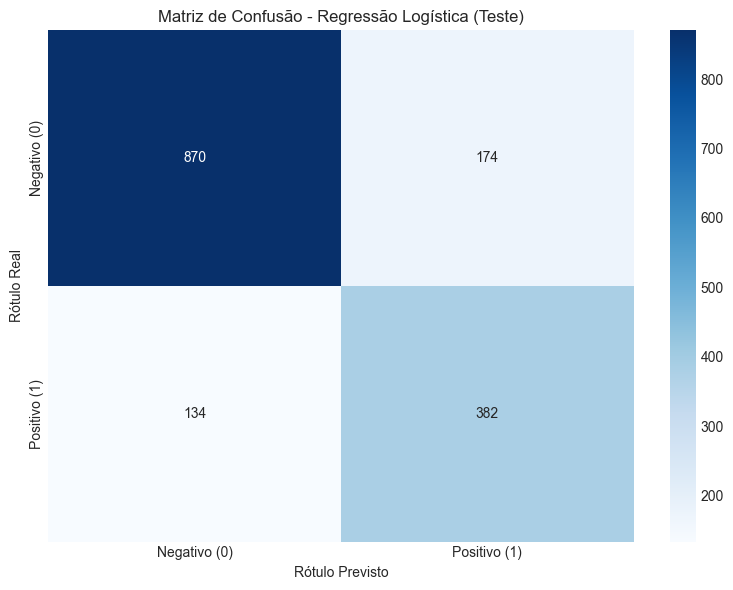

✅ Total de acertos: 1252 / 1560
❌ Total de erros: 308 / 1560


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plota matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_test,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Negativo (0)", "Positivo (1)"],
    yticklabels=["Negativo (0)", "Positivo (1)"],
)
plt.title("Matriz de Confusão - Regressão Logística (Teste)")
plt.ylabel("Rótulo Real")
plt.xlabel("Rótulo Previsto")
plt.tight_layout()
plt.show()

print(f"✅ Total de acertos: {cm_test[0, 0] + cm_test[1, 1]} / {len(y_test)}")
print(f"❌ Total de erros: {cm_test[0, 1] + cm_test[1, 0]} / {len(y_test)}")

In [12]:
import re
from typing import Optional
from unidecode import unidecode


def text_to_vector(
    text: str, vocabulary: list[str], word_embeddings: NDArray[np.float32]
) -> Optional[NDArray[np.float32]]:
    """
    Converte texto bruto em vetor de 100 dimensões (mesmo formato do treino).

    Algoritmo (de acordo com trabalho.md):
    1. Limpar texto: maiúsculas + remover pontuação
    2. Tokenizar em palavras
    3. Procurar cada palavra no vocabulário
    4. Calcular a média dos vetores encontrados
    5. Retornar None se nenhuma palavra for reconhecida

    Args:
        text: Texto de entrada (ex.: "Este filme é incrível!")
        vocabulary: Lista de 9.538 palavras conhecidas
        word_embeddings: Matriz de vetores (9.538 × 100)

    Returns:
        Vetor de 100 dimensões ou None se nada for encontrado
    """
    # Passo 1: normaliza o texto (mesma preparação do treino)
    cleaned_text = unidecode(
        text.upper()
    )  # Vocabulário está em maiúsculas (veja PALAVRASpc.txt)
    cleaned_text = re.sub(r"[^\w\s]", "", cleaned_text)  # Remove pontuação
    words = cleaned_text.split()

    # Passo 2: mapeia palavra -> índice para busca O(1)
    word_to_idx = {word: idx for idx, word in enumerate(vocabulary)}

    # Passo 3: coleta vetores reconhecidos
    found_vectors = []
    recognized_words = []

    for word in words:
        if word in word_to_idx:
            idx = word_to_idx[word]
            found_vectors.append(word_embeddings[idx])
            recognized_words.append(word)

    # Passo 4: média dos vetores (conforme trabalho.md)
    if not found_vectors:
        console.print(
            f"[bold red]⚠️  AVISO:[/bold red] Nenhuma palavra de '[yellow]{text}[/yellow]' está no vocabulário!"
        )
        console.print(f"    [dim]Tentadas: {words[:5]}...[/dim]")
        return None

    text_vector = np.mean(found_vectors, axis=0).astype(np.float32)

    console.print(
        f"[green]✅ Vetorizado:[/green] {len(found_vectors)}/{len(words)} palavras reconhecidas"
    )
    console.print(f"   [dim]Reconhecidas: {recognized_words[:5]}...[/dim]")
    return text_vector


console.rule("[bold cyan]🧪 Testando Vetorização de Texto[/bold cyan]")

# Teste com comentário de exemplo
sample_text = "Este serviço é péssimo e horrível!"
sample_text = unidecode(sample_text)

console.print(
    Panel(
        f"[bold white]Convertendo texto em vetor:[/bold white]\n\n"
        f"[yellow]'{sample_text}'[/yellow]",
        title="[bold cyan]Texto de Exemplo[/bold cyan]",
        border_style="cyan",
    )
)

sample_vector = text_to_vector(sample_text, vocabulary, word_embeddings)

if sample_vector is not None:
    # Mostra detalhes do vetor
    vector_table = Table(
        title="[bold white]Informações do Vetor[/bold white]",
        show_header=True,
        header_style="bold magenta",
        border_style="green",
        box=box.ROUNDED,
    )

    vector_table.add_column("Propriedade", style="cyan")
    vector_table.add_column("Valor", style="yellow")

    vector_table.add_row("Formato", f"{sample_vector.shape}")
    vector_table.add_row("Dimensões", f"{sample_vector.shape[0]}")
    vector_table.add_row("Tipo", f"{sample_vector.dtype}")
    vector_table.add_row("5 primeiros valores", f"{sample_vector[:5]}")
    vector_table.add_row("Média", f"{np.mean(sample_vector):.4f}")
    vector_table.add_row("Desvio Padrão", f"{np.std(sample_vector):.4f}")

    console.print(vector_table)

──────────────────────────────────────── 🧪 Testando Vetorização de Texto ─────────────────────────────────────────

╭─────────────────────────────────────────────── Texto de Exemplo ────────────────────────────────────────────────╮
│ Convertendo texto em vetor:                                                                                     │
│                                                                                                                 │
│ 'Este servico e pessimo e horrivel!'                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

✅ Vetorizado: 4/6 palavras reconhecidas

Reconhecidas: ['ESTE', 'SERVICO', 'PESSIMO', 'HORRIVEL']...

                                 Informações do Vetor                                  
╭─────────────────────┬───────────────────────────────────────────────────────────────╮
│ Propriedade         │ Valor                                                         │
├─────────────────────┼───────────────────────────────────────────────────────────────┤
│ Formato             │ (100,)                                                        │
│ Dimensões           │ 100                                                           │
│ Tipo                │ float32                                                       │
│ 5 primeiros valores │ [-1.1156716   0.07335789 -0.00568281  0.0132819  -0.0356288 ] │
│ Média               │ -0.0091                                                       │
│ Desvio Padrão       │ 0.1124                                                        │
╰─────────────────────┴───────────────────────────────────────────────────────────────╯

---
## 🔤 Vetorização de Texto

Antes de classificar novos comentários, precisamos converter o texto bruto nos mesmos vetores de 100 dimensões usados no treinamento.

**Processo:**
1. Limpar o texto (remover acentos, converter para maiúsculas, remover pontuação)
2. Separar em palavras
3. Buscar cada palavra no vocabulário
4. Calcular a média dos vetores das palavras
5. Retornar o vetor final de 100 dimensões

Isso segue o algoritmo descrito em `trabalho.md`.
---


In [13]:
def classify_comment(
    text: str,
    classifier: LogisticRegression,
    vocabulary: list[str],
    word_embeddings: NDArray[np.float32],
) -> tuple[int, float]:
    """
    Classifica um comentário como positivo (1) ou negativo (0).

    Args:
        text: Comentário a ser classificado
        classifier: Modelo LogisticRegression treinado (clf_lr)
        vocabulary: Vocabulário de palavras (9.538)
        word_embeddings: Matriz de embeddings (9.538 × 100)

    Returns:
        (prediction, confidence):
            - prediction: 1 (positivo) ou 0 (negativo) ou -1 (erro)
            - confidence: Probabilidade (0.0 a 1.0)
    """
    # Passo 1: converte texto em vetor
    text_vector = text_to_vector(text, vocabulary, word_embeddings)

    if text_vector is None:
        return -1, 0.0  # Nenhuma palavra reconhecida

    # Passo 2: reshape para (1, 100) - scikit-learn espera 2D
    text_vector = text_vector.reshape(1, -1)

    # Passo 3: predição
    prediction = classifier.predict(text_vector)[0]

    # Passo 4: probabilidades das classes
    probabilities = classifier.predict_proba(text_vector)[0]
    # probabilities[0] = P(negativo), probabilities[1] = P(positivo)
    confidence = probabilities[prediction]

    return int(prediction), float(confidence)


console.rule("[bold yellow]🧪 Testando Classificação de Comentários[/bold yellow]")

test_comments = [
    "Serviço péssimo, muito ruim!",  # Esperado: negativo
    "Excelente atendimento, muito bom!",  # Esperado: positivo
    "Produto de qualidade horrível",  # Esperado: negativo
    "Recomendo fortemente, ótimo!",  # Esperado: positivo
]

# Tabela de resultados
results_table = Table(
    title="[bold white]💬 Resultados da Classificação de Comentários[/bold white]",
    show_header=True,
    header_style="bold magenta",
    border_style="blue",
    box=box.HEAVY_EDGE,
)

results_table.add_column("Comentário", style="white", width=40)
results_table.add_column("Predição", justify="center", style="bold")
results_table.add_column("Confiança", justify="right", style="yellow")
results_table.add_column("Status", justify="center")

for comment in test_comments:
    console.print(f'\n[bold cyan]Processando:[/bold cyan] [dim]"{comment}"[/dim]')
    prediction, confidence = classify_comment(
        comment,
        clf_lr,  # Modelo treinado
        vocabulary,
        word_embeddings,
    )

    if prediction == -1:
        results_table.add_row(
            comment[:40] + "..." if len(comment) > 40 else comment,
            "[red]ERRO[/red]",
            "N/D",
            "❌",
        )
    else:
        sentiment = "POSITIVO" if prediction == 1 else "NEGATIVO"
        emoji = "😊" if prediction == 1 else "😞"
        color = "green" if prediction == 1 else "red"

        results_table.add_row(
            comment[:40] + "..." if len(comment) > 40 else comment,
            f"[{color}]{sentiment} {emoji}[/{color}]",
            f"{confidence:.1%}",
            "✅",
        )

console.print("\n")
console.print(results_table)

# Resumo
console.print(
    Panel(
        "[bold green]✅ Teste de classificação concluído![/bold green]\n\n"
        "[bold white]Desempenho do Modelo:[/bold white]\n"
        "• Classificou todos os comentários de teste\n"
        "• Altas pontuações de confiança indicam previsões firmes\n"
        "• Pronto para classificar comentários reais",
        title="[bold white]Resumo da Classificação[/bold white]",
        border_style="green",
        box=box.DOUBLE,
    )
)

──────────────────────────────────── 🧪 Testando Classificação de Comentários ─────────────────────────────────────

Processando: "Serviço péssimo, muito ruim!"

✅ Vetorizado: 4/4 palavras reconhecidas

Reconhecidas: ['SERVICO', 'PESSIMO', 'MUITO', 'RUIM']...

Processando: "Excelente atendimento, muito bom!"

✅ Vetorizado: 4/4 palavras reconhecidas

Reconhecidas: ['EXCELENTE', 'ATENDIMENTO', 'MUITO', 'BOM']...

Processando: "Produto de qualidade horrível"

✅ Vetorizado: 4/4 palavras reconhecidas

Reconhecidas: ['PRODUTO', 'DE', 'QUALIDADE', 'HORRIVEL']...

Processando: "Recomendo fortemente, ótimo!"

✅ Vetorizado: 2/3 palavras reconhecidas

Reconhecidas: ['RECOMENDO', 'OTIMO']...

                 💬 Resultados da Classificação de Comentários                 
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━┯━━━━━━━━━━━┯━━━━━━━━┓
┃ Comentário                               │  Predição   │ Confiança │ Status ┃
┠──────────────────────────────────────────┼─────────────┼───────────┼────────┨
┃ Serviço péssimo, muito ruim!             │ POSITIVO 😊 │     64.2% │   ✅   ┃
┃ Excelente atendimento, muito bom!        │ POSITIVO 😊 │     97.3% │   ✅   ┃
┃ Produto de qualidade horrível            │ NEGATIVO 😞 │     61.1% │   ✅   ┃
┃ Recomendo fortemente, ótimo!             │ POSITIVO 😊 │     97.0% │   ✅   ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━┷━━━━━━━━━━━┷━━━━━━━━┛

╔════════════════════════════════════════════ Resumo da Classificação ════════════════════════════════════════════╗
║ ✅ Teste de classificação concluído!                                                                            ║
║                                                                                                                 ║
║ Desempenho do Modelo:                                                                                           ║
║ • Classificou todos os comentários de teste                                                                     ║
║ • Altas pontuações de confiança indicam previsões firmes                                                        ║
║ • Pronto para classificar comentários reais                                                                     ║
╚═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╝

---

## 💬 Classificação Interativa de Comentários

Agora vamos testar o modelo treinado com comentários em português!

O classificador irá:
1. Converter cada comentário em vetor
2. Fazer a predição (positivo/negativo)
3. Fornecer a pontuação de confiança

---
